In [2]:
!pip install --upgrade setuptools pip --user
!pip install nvidia-pyindex
!pip install onnx_graphsurgeon
!pip install onnx 
!pip install onnxruntime
!pip install --ignore-installed PyYAML
!pip install --upgrade nvidia-tensorrt
!pip install pycuda 
!pip install protobuf<4.21.3
!pip install onnxruntime
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user
!pip install pandas
!pip install opencv-python
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:000:00:01m eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8419 sha256=4f4f79da42c0e87366bc3bb11f23058c3160d52d4c303ee6ce139e31c55aa6e7
  Stored in directory: /home/gabriel/.cache/pip/wheels/65/cd/01/fb75031f3f86f9d8940f46f7c23fc1dcd38965799131e06a7e
Successfully built nvidia-pyindex
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 26.2 MB/s eta 0:00:0031m25.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta

In [53]:
!python yolov7/export.py --weights yolov7/yolov7.pt --grid --simplify --include-nms --topk-all 20 --batch-size 12

Namespace(batch_size=1, conf_thres=0.25, device='cpu', dynamic=False, dynamic_batch=True, end2end=False, fp16=False, grid=True, img_size=[640, 640], include_nms=True, int8=False, iou_thres=0.45, max_wh=None, simplify=True, topk_all=100, weights='yolov7/yolov7.pt')
YOLOR 🚀 2022-9-5 torch 1.12.0+cu102 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 36905341 gradients
/home/gabriel/miniconda3/envs/trt/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Starting TorchScript export with torch 1.12.0+cu102...
/home/gabriel/aircraft-detection/yolov7/models/yolo.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to b

In [20]:
!python tensorrt-python/export.py -o yolov7/yolov7.onnx -e yolov7-single.trt -p fp16

Namespace(calib_batch_size=8, calib_cache='./calibration.cache', calib_input=None, calib_num_images=5000, conf_thres=0.4, end2end=False, engine='yolov7-single.trt', iou_thres=0.5, max_det=100, onnx='yolov7/yolov7.onnx', precision='fp16', verbose=False, workspace=1)
[11/02/2022-03:41:34] [TRT] [I] [MemUsageChange] Init CUDA: CPU +320, GPU +0, now: CPU 344, GPU 2884 (MiB)
[11/02/2022-03:41:35] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +327, GPU +103, now: CPU 690, GPU 2985 (MiB)
tensorrt-python/export.py:109: DeprecationWarning: Use set_memory_pool_limit instead.
  self.config.max_workspace_size = workspace * (2 ** 30)
[11/02/2022-03:41:35] [TRT] [W] onnx2trt_utils.cpp:369: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[11/02/2022-03:41:35] [TRT] [W] onnx2trt_utils.cpp:395: One or more weights outside the range of INT32 was clamped
[11/02/2022-03:41:35] [TRT] [I] No importer regis

[11/02/2022-03:43:20] [TRT] [W] Weights [name=Conv_12 + PWN(PWN(Sigmoid_13), Mul_14).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:20] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:20] [TRT] [W]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[11/02/2022-03:43:20] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:20] [TRT] [W] Weights [name=Conv_12 + PWN(PWN(Sigmoid_13), Mul_14).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:20] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:20] [TRT] [W]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[11/02/2022-03:43:20] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with reg

[11/02/2022-03:43:21] [TRT] [W] Weights [name=Conv_15 || Conv_18.weight] had the following issues when converted to FP16:
[11/02/2022-03:43:21] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:21] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:21] [TRT] [W] Weights [name=Conv_15 || Conv_18.weight] had the following issues when converted to FP16:
[11/02/2022-03:43:21] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:21] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:51] [TRT] [W] Weights [name=Conv_21 + PWN(PWN(Sigmoid_22), Mul_23).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:51] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:51] [TRT] [W] If this is not the desired behavior, please mo

[11/02/2022-03:43:54] [TRT] [W] Weights [name=Conv_27 + PWN(PWN(Sigmoid_28), Mul_29).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:54] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:54] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:54] [TRT] [W] Weights [name=Conv_30 + PWN(PWN(Sigmoid_31), Mul_32).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:54] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:54] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:54] [TRT] [W] Weights [name=Conv_30 + PWN(PWN(Sigmoid_31), Mul_32).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:54] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:54] [TRT] [W] If thi

[11/02/2022-03:43:56] [TRT] [W] Weights [name=Conv_41 + PWN(PWN(Sigmoid_42), Mul_43).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:56] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:56] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:56] [TRT] [W] Weights [name=Conv_41 + PWN(PWN(Sigmoid_42), Mul_43).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:56] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:56] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:57] [TRT] [W] Weights [name=Conv_38 + PWN(PWN(Sigmoid_39), Mul_40).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:57] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:57] [TRT] [W] If thi

[11/02/2022-03:43:59] [TRT] [W] Weights [name=Conv_44 + PWN(PWN(Sigmoid_45), Mul_46).weight] had the following issues when converted to FP16:
[11/02/2022-03:43:59] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:59] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:59] [TRT] [W] Weights [name=Conv_48 || Conv_51.weight] had the following issues when converted to FP16:
[11/02/2022-03:43:59] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:59] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:43:59] [TRT] [W] Weights [name=Conv_48 || Conv_51.weight] had the following issues when converted to FP16:
[11/02/2022-03:43:59] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:43:59] [TRT] [W] If this is not the desired behavior, please mo

[11/02/2022-03:44:02] [TRT] [W] Weights [name=Conv_57 + PWN(PWN(Sigmoid_58), Mul_59).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:02] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:02] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:02] [TRT] [W] Weights [name=Conv_57 + PWN(PWN(Sigmoid_58), Mul_59).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:02] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:02] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:02] [TRT] [W] Weights [name=Conv_57 + PWN(PWN(Sigmoid_58), Mul_59).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:02] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:02] [TRT] [W] If thi

[11/02/2022-03:44:04] [TRT] [W] Weights [name=Conv_67 + PWN(PWN(Sigmoid_68), Mul_69).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:04] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:04] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:04] [TRT] [W] Weights [name=Conv_67 + PWN(PWN(Sigmoid_68), Mul_69).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:04] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:04] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:05] [TRT] [W] Weights [name=Conv_74 || Conv_198.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:05] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:05] [TRT] [W] If this is not the desire

[11/02/2022-03:44:06] [TRT] [W] Weights [name=Conv_71 + PWN(PWN(Sigmoid_72), Mul_73).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:06] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:06] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:06] [TRT] [W] Weights [name=Conv_71 + PWN(PWN(Sigmoid_72), Mul_73).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:06] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:06] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:08] [TRT] [W] Weights [name=Conv_77 + PWN(PWN(Sigmoid_78), Mul_79).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:08] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:08] [TRT] [W] If thi

[11/02/2022-03:44:10] [TRT] [W] Weights [name=Conv_87 + PWN(PWN(Sigmoid_88), Mul_89).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:10] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:10] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:10] [TRT] [W] Weights [name=Conv_87 + PWN(PWN(Sigmoid_88), Mul_89).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:10] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:10] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:10] [TRT] [W] Weights [name=Conv_87 + PWN(PWN(Sigmoid_88), Mul_89).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:10] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:10] [TRT] [W] If thi

[11/02/2022-03:44:13] [TRT] [W] Weights [name=Conv_96 + PWN(PWN(Sigmoid_97), Mul_98).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:13] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:13] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:13] [TRT] [W] Weights [name=Conv_96 + PWN(PWN(Sigmoid_97), Mul_98).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:13] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:13] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:13] [TRT] [W] Weights [name=Conv_96 + PWN(PWN(Sigmoid_97), Mul_98).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:13] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:13] [TRT] [W] If thi

[11/02/2022-03:44:15] [TRT] [W] Weights [name=Conv_107 || Conv_167.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:15] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:15] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:15] [TRT] [W] Weights [name=Conv_107 || Conv_167.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:15] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:15] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:15] [TRT] [W] Weights [name=Conv_107 || Conv_167.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:15] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:15] [TRT] [W] If this is not the desired behavior, please modify the weigh

[11/02/2022-03:44:18] [TRT] [W] Weights [name=Conv_110 + PWN(PWN(Sigmoid_111), Mul_112).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:18] [TRT] [W] Weights [name=Conv_110 + PWN(PWN(Sigmoid_111), Mul_112).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:18] [TRT] [W] Weights [name=Conv_110 + PWN(PWN(Sigmoid_111), Mul_112).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:18] [TRT] [

[11/02/2022-03:44:22] [TRT] [W] Weights [name=Conv_120 + PWN(PWN(Sigmoid_121), Mul_122).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:22] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:22] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:22] [TRT] [W] Weights [name=Conv_120 + PWN(PWN(Sigmoid_121), Mul_122).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:22] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:22] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:22] [TRT] [W] Weights [name=Conv_120 + PWN(PWN(Sigmoid_121), Mul_122).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:22] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:22] [TRT] [

[11/02/2022-03:44:24] [TRT] [W] Weights [name=Conv_129 + PWN(PWN(Sigmoid_130), Mul_131).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:24] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:24] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:24] [TRT] [W] Weights [name=Conv_129 + PWN(PWN(Sigmoid_130), Mul_131).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:24] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:24] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:24] [TRT] [W] Weights [name=Conv_129 + PWN(PWN(Sigmoid_130), Mul_131).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:24] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:24] [TRT] [

[11/02/2022-03:44:26] [TRT] [W] Weights [name=Conv_136 || Conv_155.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:26] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:26] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:26] [TRT] [W] Weights [name=Conv_136 || Conv_155.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:26] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:26] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:26] [TRT] [W] Weights [name=Conv_136 || Conv_155.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:26] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:26] [TRT] [W] If this is not the desired behavior, please modify the weigh

[11/02/2022-03:44:31] [TRT] [W] Weights [name=Conv_142 + PWN(PWN(Sigmoid_143), Mul_144).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:31] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:31] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:31] [TRT] [W] Weights [name=Conv_142 + PWN(PWN(Sigmoid_143), Mul_144).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:31] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:31] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:32] [TRT] [W] Weights [name=Conv_149 + PWN(PWN(Sigmoid_150), Mul_151).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:32] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:32] [TRT] [

[11/02/2022-03:44:34] [TRT] [W] Weights [name=Conv_152 + PWN(PWN(Sigmoid_153), Mul_154).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:34] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:34] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:35] [TRT] [W] Weights [name=Conv_159 + PWN(PWN(Sigmoid_160), Mul_161).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:35] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:35] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:35] [TRT] [W] Weights [name=Conv_159 + PWN(PWN(Sigmoid_160), Mul_161).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:35] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:35] [TRT] [

[11/02/2022-03:44:36] [TRT] [W] Weights [name=Conv_162 + PWN(PWN(Sigmoid_163), Mul_164).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:36] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:36] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:36] [TRT] [W] Weights [name=Conv_162 + PWN(PWN(Sigmoid_163), Mul_164).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:36] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:36] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:36] [TRT] [W] Weights [name=Conv_171 || Conv_174.weight] had the following issues when converted to FP16:
[11/02/2022-03:44:36] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:36] [TRT] [W] If this is not the

[11/02/2022-03:44:39] [TRT] [W] Weights [name=Conv_180 + PWN(PWN(Sigmoid_181), Mul_182).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:39] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:39] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:40] [TRT] [W] Weights [name=Conv_183 + PWN(PWN(Sigmoid_184), Mul_185).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:40] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:40] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:40] [TRT] [W] Weights [name=Conv_183 + PWN(PWN(Sigmoid_184), Mul_185).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:40] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:40] [TRT] [

[11/02/2022-03:44:42] [TRT] [W] Weights [name=Conv_190 + PWN(PWN(Sigmoid_191), Mul_192).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:42] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:42] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:42] [TRT] [W] Weights [name=Conv_190 + PWN(PWN(Sigmoid_191), Mul_192).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:42] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:42] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:42] [TRT] [W] Weights [name=Conv_193 + PWN(PWN(Sigmoid_194), Mul_195).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:42] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:42] [TRT] [

[11/02/2022-03:44:44] [TRT] [W] Weights [name=Conv_208 + PWN(PWN(Sigmoid_209), Mul_210).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:44] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:44] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:44] [TRT] [W] Weights [name=Conv_208 + PWN(PWN(Sigmoid_209), Mul_210).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:44] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:44] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:44] [TRT] [W] Weights [name=Conv_208 + PWN(PWN(Sigmoid_209), Mul_210).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:44] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:44] [TRT] [

[11/02/2022-03:44:47] [TRT] [W] Weights [name=Conv_217 + PWN(PWN(Sigmoid_218), Mul_219).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:47] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:47] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:47] [TRT] [W] Weights [name=Conv_217 + PWN(PWN(Sigmoid_218), Mul_219).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:47] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:47] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:47] [TRT] [W] Weights [name=Conv_217 + PWN(PWN(Sigmoid_218), Mul_219).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:47] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:47] [TRT] [

[11/02/2022-03:44:50] [TRT] [W] Weights [name=Conv_228 + PWN(PWN(Sigmoid_229), Mul_230).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:50] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:50] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:50] [TRT] [W] Weights [name=Conv_228 + PWN(PWN(Sigmoid_229), Mul_230).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:50] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:50] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:51] [TRT] [W] Weights [name=Conv_290 + PWN(PWN(Sigmoid_291), Mul_292).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:51] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:51] [TRT] [

[11/02/2022-03:44:52] [TRT] [W] Weights [name=Conv_225 + PWN(PWN(Sigmoid_226), Mul_227).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:52] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:52] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:52] [TRT] [W] Weights [name=Conv_225 + PWN(PWN(Sigmoid_226), Mul_227).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:52] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:52] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:44:53] [TRT] [W] Weights [name=Conv_231 + PWN(PWN(Sigmoid_232), Mul_233).weight] had the following issues when converted to FP16:
[11/02/2022-03:44:53] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:44:53] [TRT] [

[11/02/2022-03:45:37] [TRT] [W] Weights [name=Conv_235 || Conv_238.weight] had the following issues when converted to FP16:
[11/02/2022-03:45:37] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:45:37] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:45:37] [TRT] [W] Weights [name=Conv_235 || Conv_238.weight] had the following issues when converted to FP16:
[11/02/2022-03:45:37] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:45:37] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:45:37] [TRT] [W] Weights [name=Conv_235 || Conv_238.weight] had the following issues when converted to FP16:
[11/02/2022-03:45:37] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:45:37] [TRT] [W] If this is not the desired behavior, please modify the weigh

[11/02/2022-03:47:09] [TRT] [W] Weights [name=Conv_250 + PWN(PWN(Sigmoid_251), Mul_252).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:09] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:09] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:09] [TRT] [W] Weights [name=Conv_250 + PWN(PWN(Sigmoid_251), Mul_252).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:09] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:09] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:09] [TRT] [W] Weights [name=Conv_250 + PWN(PWN(Sigmoid_251), Mul_252).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:09] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:09] [TRT] [

[11/02/2022-03:47:11] [TRT] [W] Weights [name=Conv_261 + PWN(PWN(Sigmoid_262), Mul_263).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:11] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:11] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:11] [TRT] [W] Weights [name=Conv_261 + PWN(PWN(Sigmoid_262), Mul_263).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:11] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:11] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:12] [TRT] [W] Weights [name=Conv_293 + PWN(PWN(Sigmoid_294), Mul_295).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:12] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:12] [TRT] [

[11/02/2022-03:47:14] [TRT] [W] Weights [name=Conv_258 + PWN(PWN(Sigmoid_259), Mul_260).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:14] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:14] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:14] [TRT] [W] Weights [name=Conv_258 + PWN(PWN(Sigmoid_259), Mul_260).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:14] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:14] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:15] [TRT] [W] Weights [name=Conv_264 + PWN(PWN(Sigmoid_265), Mul_266).weight] had the following issues when converted to FP16:
[11/02/2022-03:47:15] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:15] [TRT] [

[11/02/2022-03:47:17] [TRT] [W] Weights [name=Conv_314.weight] had the following issues when converted to FP16:
[11/02/2022-03:47:17] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:17] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:17] [TRT] [W] Weights [name=Conv_314.weight] had the following issues when converted to FP16:
[11/02/2022-03:47:17] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:17] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:47:22] [TRT] [W] Weights [name=Conv_268 || Conv_271.weight] had the following issues when converted to FP16:
[11/02/2022-03:47:22] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:47:22] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regul

[11/02/2022-03:48:16] [TRT] [W] Weights [name=Conv_277 + PWN(PWN(Sigmoid_278), Mul_279).weight] had the following issues when converted to FP16:
[11/02/2022-03:48:16] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:16] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:48:17] [TRT] [W] Weights [name=Conv_280 + PWN(PWN(Sigmoid_281), Mul_282).weight] had the following issues when converted to FP16:
[11/02/2022-03:48:17] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:17] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:48:17] [TRT] [W] Weights [name=Conv_280 + PWN(PWN(Sigmoid_281), Mul_282).weight] had the following issues when converted to FP16:
[11/02/2022-03:48:17] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:17] [TRT] [

[11/02/2022-03:48:18] [TRT] [W] Weights [name=Conv_287 + PWN(PWN(Sigmoid_288), Mul_289).weight] had the following issues when converted to FP16:
[11/02/2022-03:48:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:48:19] [TRT] [W] Weights [name=Conv_296 + PWN(PWN(Sigmoid_297), Mul_298).weight] had the following issues when converted to FP16:
[11/02/2022-03:48:19] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:19] [TRT] [W]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[11/02/2022-03:48:19] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:48:19] [TRT] [W] Weights [name=Conv_296 + PWN(PWN(Sigmoid_297), Mul_298).weig

[11/02/2022-03:48:22] [TRT] [W] Weights [name=Conv_329.weight] had the following issues when converted to FP16:
[11/02/2022-03:48:22] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:22] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:48:22] [TRT] [W] Weights [name=Conv_329.weight] had the following issues when converted to FP16:
[11/02/2022-03:48:22] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:48:22] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:18] [TRT] [I] Detected 1 inputs and 4 output network tensors.
[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_6 + PWN(PWN(Sigmoid_7), Mul_8).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18]

[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_100 + PWN(PWN(Sigmoid_101), Mul_102).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_107 || Conv_167.weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_104 + PWN(PWN(Sigmoid_105), Mul_106).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18] [TRT] [W] If this is not the

[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_228 + PWN(PWN(Sigmoid_229), Mul_230).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_290 + PWN(PWN(Sigmoid_291), Mul_292).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:18] [TRT] [W] Weights [name=Conv_225 + PWN(PWN(Sigmoid_226), Mul_227).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:18] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:18] [TRT] [

[11/02/2022-03:49:19] [TRT] [W] Weights [name=Conv_296 + PWN(PWN(Sigmoid_297), Mul_298).weight] had the following issues when converted to FP16:
[11/02/2022-03:49:19] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:19] [TRT] [W]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[11/02/2022-03:49:19] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:19] [TRT] [W] Weights [name=Conv_329.weight] had the following issues when converted to FP16:
[11/02/2022-03:49:19] [TRT] [W]  - Subnormal FP16 values detected. 
[11/02/2022-03:49:19] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[11/02/2022-03:49:19] [TRT] [I] Total Host Persistent Memory: 214880
[11/02/2022-03:49:19] [TRT] [I] Total Device Persistent 

In [1]:
import utils.dataset as dataset
import utils.object_detector as od
import numpy as np
import torch
import matplotlib.pyplot as plt
#static camera properties
dataset_directory = "/media/gabriel/DATA/dataset"
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048]

data_indexes = [1,2]
data_sources = []
t = 2
r = 1
w = 5

for data_index in data_indexes:
    data_sources.append([f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'])
    
acd = dataset.aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

a = od.auto_segmentation()

aircraft-detection custom utils


In [36]:
img = acd.get_frame_from_video(4000, size = (1280, 1920))
centroid = a.update_box(img)

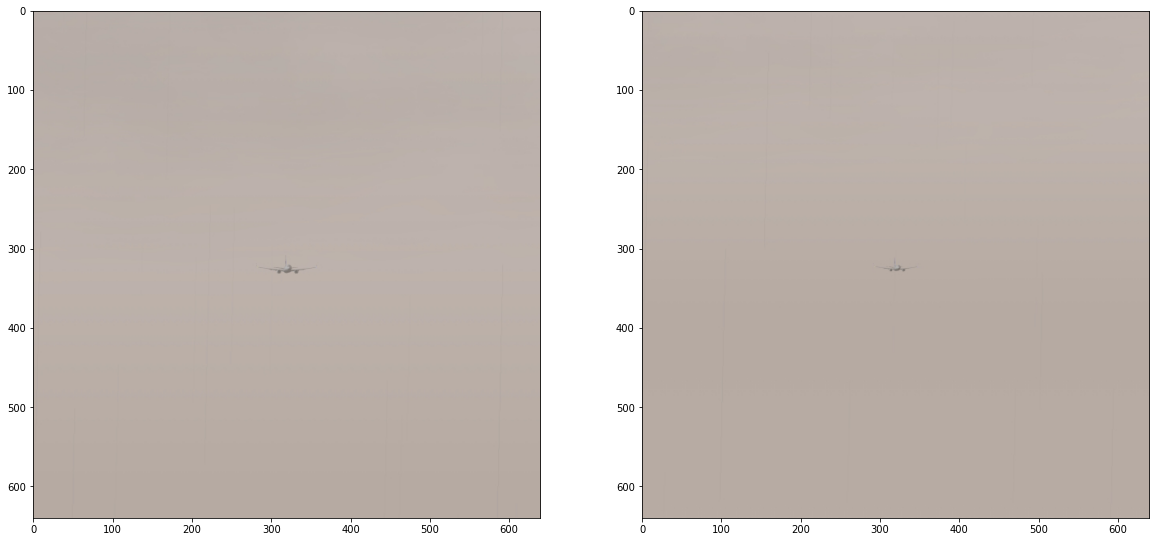

In [38]:
a.vis_current_box(img, centroid)

In [16]:
origin = a.origins

In [28]:
new_img = img[0][0][y_center-320:y_center+320, x_center-320:x_center+320]

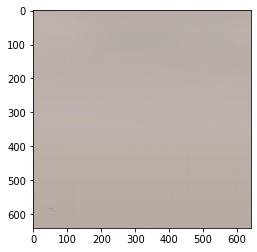

In [31]:
plt.imshow(new_img)